In [1]:
import sys
sys.path.insert(1, '/Users/jeanettemumford/Dropbox/Research/Projects/RT_sims/Code')
from functions import *
%matplotlib inline

/Users/jeanettemumford/.pyenv/versions/3.8.5/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [56]:
from nilearn.glm.first_level.design_matrix import _cosine_drift
def est_win_sub_mod_sd(n_trials, scan_length, repetition_time=1, mu_expnorm=600,
              lam_expnorm=1 / 100, sigma_expnorm=75, max_rt=2000, 
              min_rt=0, event_duration=2, ISI_min=2, ISI_max=5, center_rt=True,
              hp_filter=True, nsim=100):
    rt_dur_des_sd = []
    zero_dur_des_sd = []
    for i in range(0, nsim):
        regressors, _ = make_regressors_one_trial_type(n_trials, scan_length, 
                                   repetition_time, mu_expnorm, 
                                   lam_expnorm, sigma_expnorm,
                                   max_rt, min_rt, event_duration, ISI_min, ISI_max, center_rt)
        reg_shape = (scan_length, 1)
        x_duration_0 = np.concatenate((np.ones(reg_shape),
                    regressors['fixed_zero']['unmodulated'],
                    regressors['fixed_zero']['modulated']), axis=1)
        x_duration_event_duration = np.concatenate((np.ones(reg_shape),
                    regressors['fixed_event_duration']['unmodulated'],
                    regressors['fixed_event_duration']['modulated']), axis=1)
        x_duration_mean_rt = np.concatenate((np.ones(reg_shape),
                    regressors['fixed_mean_rt']['unmodulated'],
                    regressors['fixed_mean_rt']['modulated']), axis=1)
        x_duration_rt_only = np.concatenate((np.ones(reg_shape),
                    regressors['rt']['unmodulated']), axis=1)
        x_duration_event_only = np.concatenate((np.ones(reg_shape),
                    regressors['fixed_event_duration']['unmodulated']), axis=1)
        x_duration_event_duration_rt_orth = np.concatenate((np.ones(reg_shape),
                    regressors['fixed_event_duration']['unmodulated'],
                    regressors['rt_orth']['unmodulated']), axis=1)

        models = {'Impulse Duration': x_duration_0,
              'Fixed/RT Duration (orth)': x_duration_event_duration_rt_orth,
              'Stimulus Duration': x_duration_event_duration,
              'Mean RT Duration': x_duration_mean_rt,
              'RT Duration only': x_duration_rt_only,
              'No RT effect': x_duration_event_only}
        win_sub_var_est =  {key: {} for key in models}
        for model_name, model_mtx in models.items():
            if hp_filter == True:
                n_time_points = model_mtx.shape[0]
                dct_basis = _cosine_drift(.01, np.arange(n_time_points))
                dct_basis = np.delete(dct_basis, -1, axis = 1)
                model_mtx = np.concatenate((model_mtx, dct_basis), axis = 1)
            win_sub_var_est[model_name] = np.linalg.inv(model_mtx.T.dot(model_mtx))[1, 1]
        rt_dur_des_sd.append(np.sqrt(win_sub_var_est['RT Duration only']))
        zero_dur_des_sd.append(np.sqrt(win_sub_var_est['Impulse Duration']))
        output = {'des_sd_rt_dur': np.mean(rt_dur_des_sd), 
                  'des_sd_zero_dur': np.mean(zero_dur_des_sd)}
    return(output)

In [82]:

n_trials = 30
scan_length = 225
repetition_time = 1
mu_grinband_shift = 642.35
inv_lambda_grinband_shift = 689.75
sigma_grinband_shift = 104.80
#mu_expnorm = 530
#lam_expnorm = 1 / 160
#sigma_expnorm = 77
mu_expnorm = mu_grinband_shift
lam_expnorm = 1 / inv_lambda_grinband_shift
sigma_expnorm = sigma_grinband_shift
max_rt = 8000
min_rt = 50
event_duration = .5
beta_scales_yes = 5
beta_scales_no = 20
center_rt=True
hp_filter = True

ISI_min = 3
ISI_max = 6

nsim = 500
nsub = 10
win_sub_noise_sd = 2.5 
btwn_sub_noise_sd = 7  # I think i'll go between 5-9?  With within sd = 2.5


out_est_win_sub_mod_sd = est_win_sub_mod_sd(n_trials, scan_length, repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, center_rt,
              hp_filter, nsim)
print(out_est_win_sub_mod_sd)


# For Grinband, scales = YES, use win_sub_noise_sd=2.5 and btwn should range between 7-9 
# For scalse = NO, win_sub_noise_sd = .5



{'des_sd_rt_dur': 0.6535215617192018, 'des_sd_zero_dur': 18.76375450798936}


In [90]:
win_sub_noise_sd = 2.5
btwn_sub_noise_sd = 7
print('For RT Duration')

des_sd = out_est_win_sub_mod_sd['des_sd_rt_dur'] 
mfx_sd = np.sqrt((win_sub_noise_sd*des_sd)**2 + btwn_sub_noise_sd**2)
print(f"mfx sd = {mfx_sd}")
print(f"des sd x noise sd = {des_sd*win_sub_noise_sd}")
print('ratio of total sd to within-sub sd')
print(mfx_sd/(des_sd*win_sub_noise_sd))
print('Cohens D estimate')
print(beta_scales_yes/mfx_sd)
print('~~~~~~~~~~~~~~')
print('For Zero Duration')
win_sub_noise_sd = .5
btwn_sub_noise_sd = 50
des_sd = out_est_win_sub_mod_sd['des_sd_zero_dur'] 
mfx_sd = np.sqrt((win_sub_noise_sd*des_sd)**2 + btwn_sub_noise_sd**2)
print(f"mfx sd = {mfx_sd}")
print(f"des sd x noise sd = {des_sd*win_sub_noise_sd}")
print('ratio of total sd to within-sub sd')
print(mfx_sd/(des_sd*win_sub_noise_sd))
print('Cohens D estimate')
print(beta_scales_no/mfx_sd)

For RT Duration
mfx sd = 7.188137115950099
des sd x noise sd = 1.6338039042980046
ratio of total sd to within-sub sd
4.399632720328588
Cohens D estimate
0.6955905152261582
~~~~~~~~~~~~~~
For Zero Duration
mfx sd = 50.87258221094171
des sd x noise sd = 9.38187725399468
ratio of total sd to within-sub sd
5.4224310160614
Cohens D estimate
0.5897086150572396


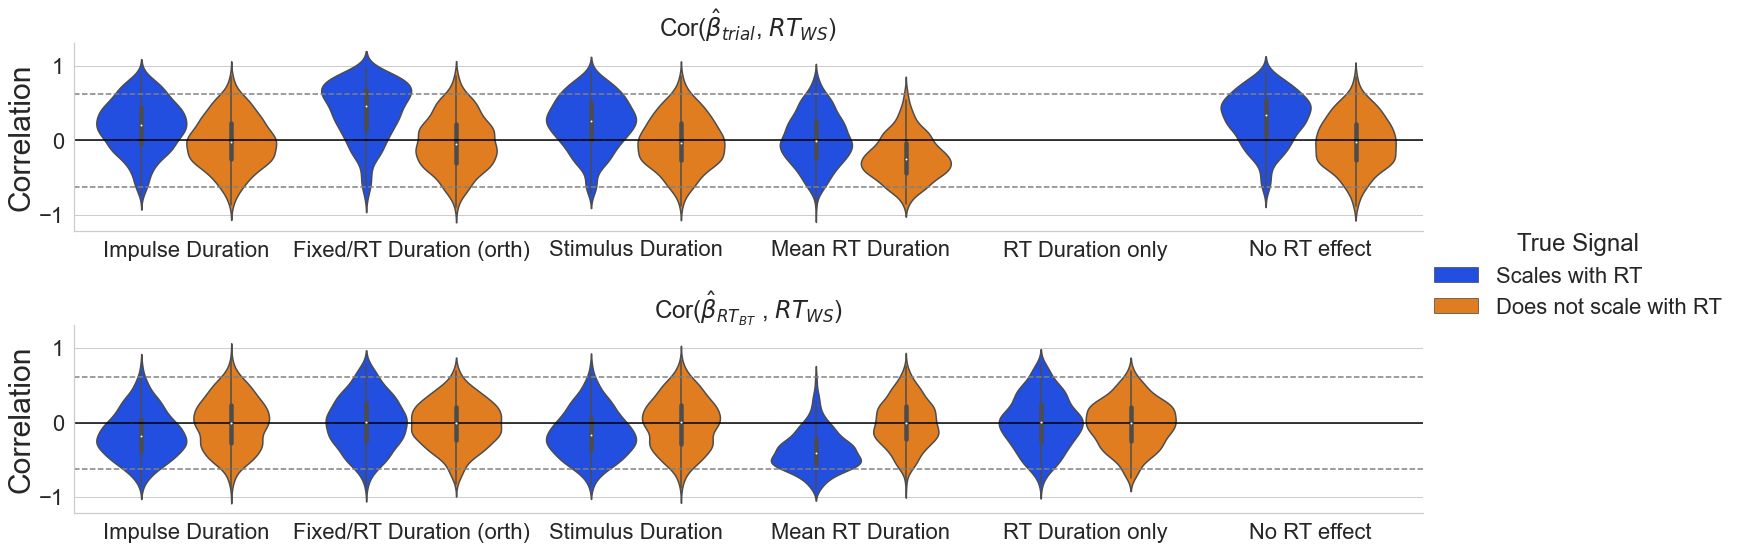

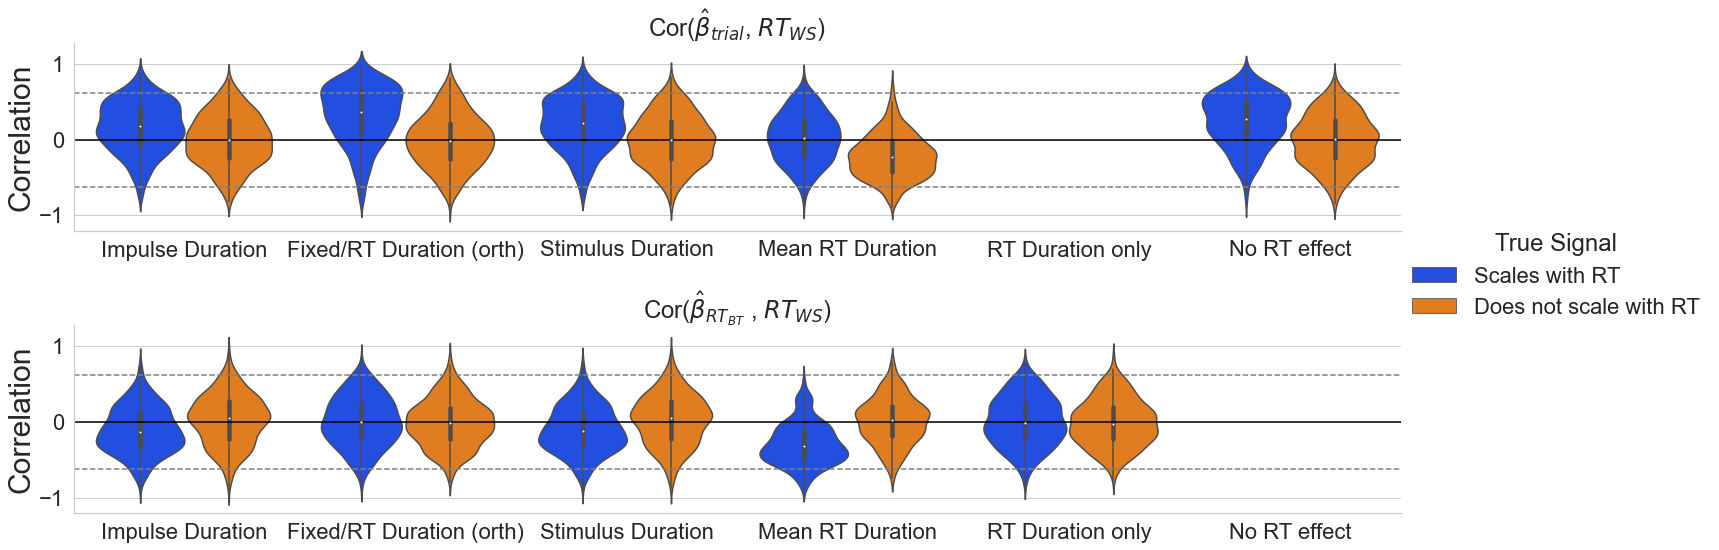

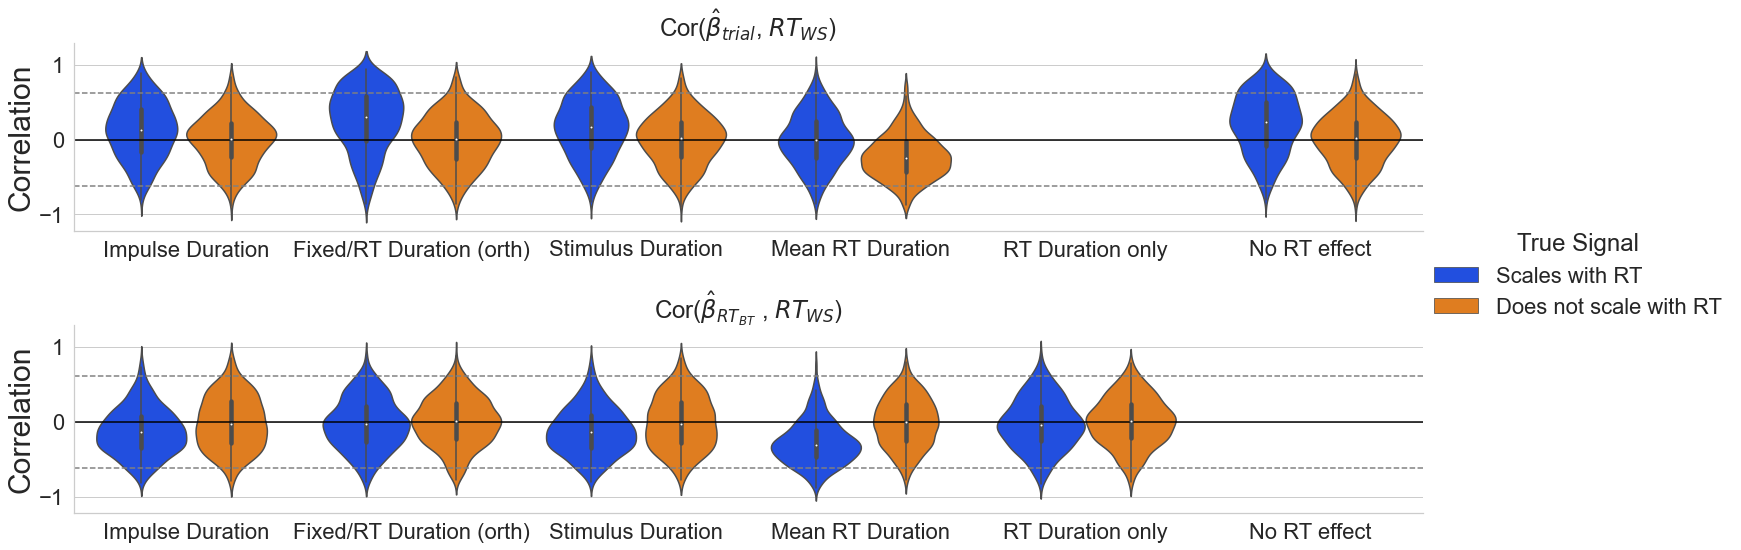

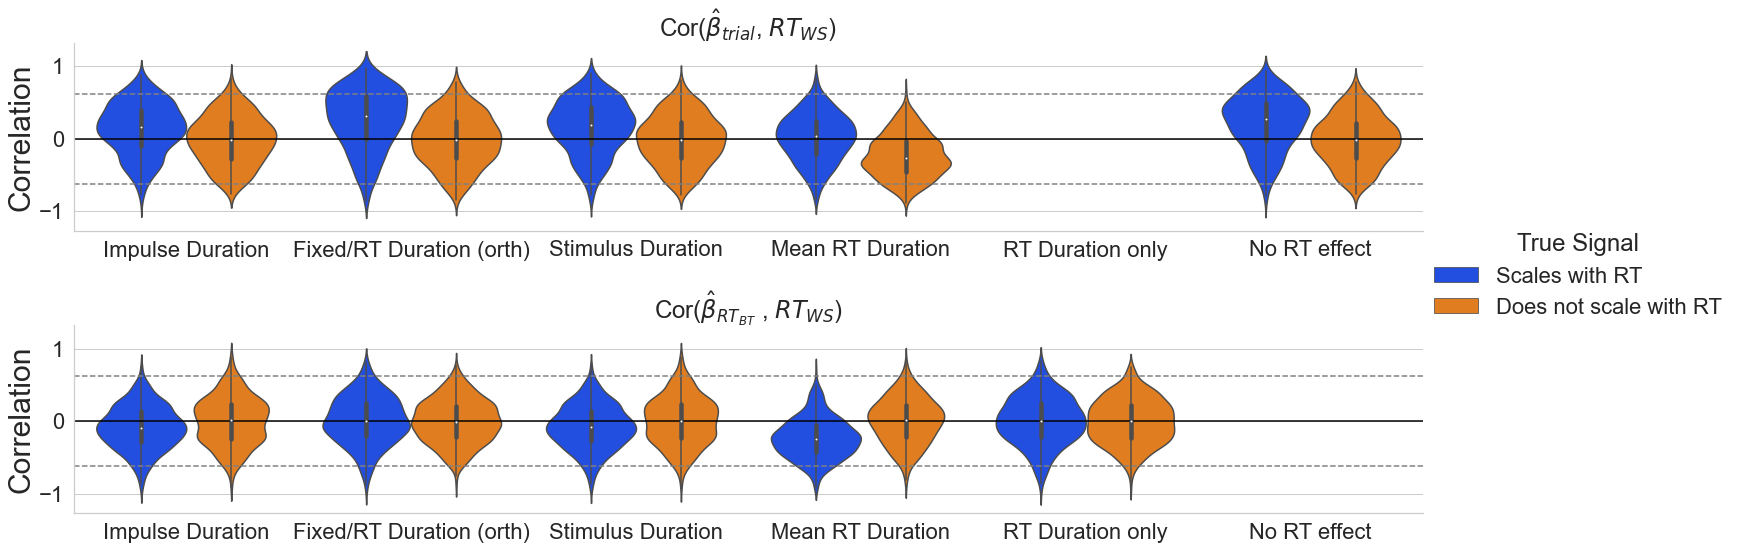

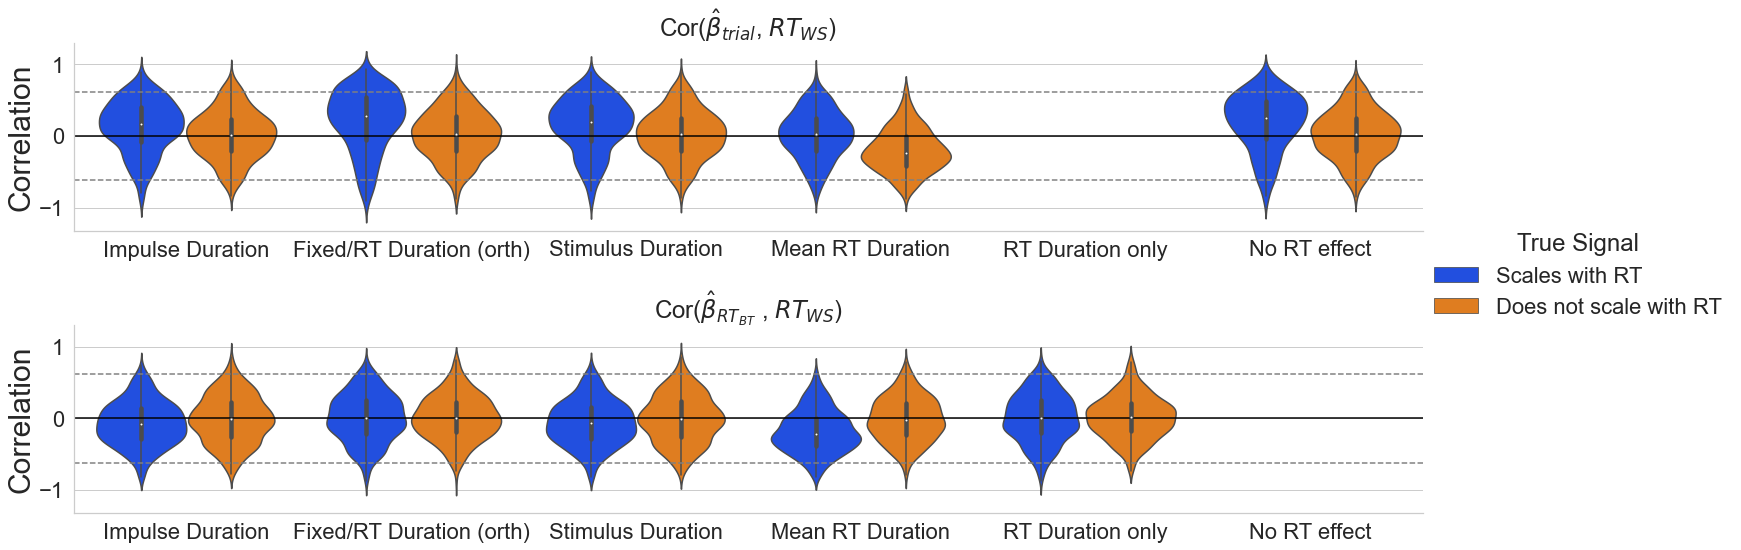

In [9]:
btwn_sub_noise_sd_vec = [4, 5, 6, 7, 9]

unmod_1sampt_pow, rtmod_1sampt_pow = group_power(n_trials, scan_length, repetition_time, 
              mu_expnorm, lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, win_sub_noise_sd, btwn_sub_noise_sd_vec, nsub, nsim, 
              center_rt, beta_scales_yes, beta_scales_no, hp_filter)

In [11]:
print(unmod_1sampt_pow)
print(rtmod_1sampt_pow)

{'dv_scales_yes': {'Impulse Duration': (0.67, 0.534, 0.478, 0.378, 0.268), 'Fixed/RT Duration (orth)': (0.744, 0.606, 0.512, 0.414, 0.296), 'Stimulus Duration': (0.71, 0.552, 0.492, 0.392, 0.28), 'Mean RT Duration': (0.746, 0.608, 0.536, 0.434, 0.306), 'RT Duration only': (0.0, 0.0, 0.0, 0.0, 0.0), 'No RT effect': (0.572, 0.412, 0.386, 0.322, 0.226)}, 'dv_scales_no': {'Impulse Duration': (0.482, 0.402, 0.454, 0.456, 0.434), 'Fixed/RT Duration (orth)': (0.422, 0.352, 0.432, 0.408, 0.384), 'Stimulus Duration': (0.468, 0.39, 0.434, 0.444, 0.428), 'Mean RT Duration': (0.38, 0.326, 0.36, 0.354, 0.344), 'RT Duration only': (0.0, 0.0, 0.0, 0.0, 0.0), 'No RT effect': (0.466, 0.402, 0.46, 0.464, 0.436)}}
{'dv_scales_yes': {'Impulse Duration': (0.844, 0.674, 0.558, 0.468, 0.33), 'Fixed/RT Duration (orth)': (0.914, 0.73, 0.596, 0.494, 0.348), 'Stimulus Duration': (0.856, 0.682, 0.56, 0.47, 0.324), 'Mean RT Duration': (0.798, 0.616, 0.502, 0.396, 0.284), 'RT Duration only': (0.91, 0.752, 0.616, 0.

In [41]:
def power_plot_group(unmod_output_power, rtmod_output_power, btwn_sub_noise_sd_vec, sim_type='dv_scales_yes',
                    zoom=False):
    #fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
    fig = plt.figure()
    axs = plt.subplot(111, frameon=False)
    #fig.add_subplot(111, frameon=False)
    #plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Between-subject SD")
    plt.ylabel("Power")
    if zoom!=False:
        plt.setp(axs, xlim=zoom)
    line1, = axs.plot(
                     btwn_sub_noise_sd_vec, 
                     rtmod_output_power[sim_type]['RT Duration only'], 
                     'tab:blue', label = 'RT duration')
    line2, = axs.plot(
                    btwn_sub_noise_sd_vec, 
                    unmod_output_power[sim_type]['Impulse Duration'], 
                    'tab:green', label = 'Const (impulse)') 
    line3,  = axs.plot(
                    btwn_sub_noise_sd_vec, 
                    rtmod_output_power[sim_type]['Impulse Duration'], 
                    'tab:green', linestyle = 'dashed', label = 'RT modulated (impulse)')
    line4, = axs.plot(
                    btwn_sub_noise_sd_vec, 
                    unmod_output_power[sim_type]['Fixed/RT Duration (orth)'], 
                    color='tab:orange', label = 'Const (stimulus duration)') 
    line5,  = axs.plot(
                    btwn_sub_noise_sd_vec, 
                    rtmod_output_power[sim_type]['Fixed/RT Duration (orth)'], 
                    color='tab:orange',linestyle='dashed', label = 'Orthogonalized RT duration')
    line6,  = axs.plot(
                    btwn_sub_noise_sd_vec, 
                    unmod_output_power[sim_type]['Stimulus Duration'], 
                    color='tab:purple', label = 'Const (stimulus duration)')
    line7,  = axs.plot(
                    btwn_sub_noise_sd_vec, 
                    rtmod_output_power[sim_type]['Stimulus Duration'], 
                    color='tab:purple',linestyle='dashed', label = 'RT modulated (stimulus duration)')
    line8,  = axs.plot(
                    btwn_sub_noise_sd_vec, 
                    unmod_output_power[sim_type]['Mean RT Duration'], 
                    color='tab:red', label = 'Const (Mean RT duration)')
    line9,  = axs.plot(
                    btwn_sub_noise_sd_vec, 
                    rtmod_output_power[sim_type]['Mean RT Duration'], 
                    color='tab:red',linestyle='dashed', label = 'RT modulated (mean RT duration)')
    line10,  = axs.plot(
                    btwn_sub_noise_sd_vec, 
                    unmod_output_power[sim_type]['No RT effect'], 
                    color='tab:olive', label = 'Const (stimulus duration)')
        #axs[panel_row, panel_col].set_xscale('log') 
    #axs[panel_row, panel_col].set_title(f'ISI=U{isi_labels[i]}')
    fig.tight_layout()
    #plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8, line9, line10], 
    #           loc='center right', bbox_to_anchor=(panel_col+1.9, panel_row/2+1), ncol=1)
    plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8, line9, line10], 
              loc='center right', bbox_to_anchor=(2.5, 1/2), ncol=1)
    plt.show()

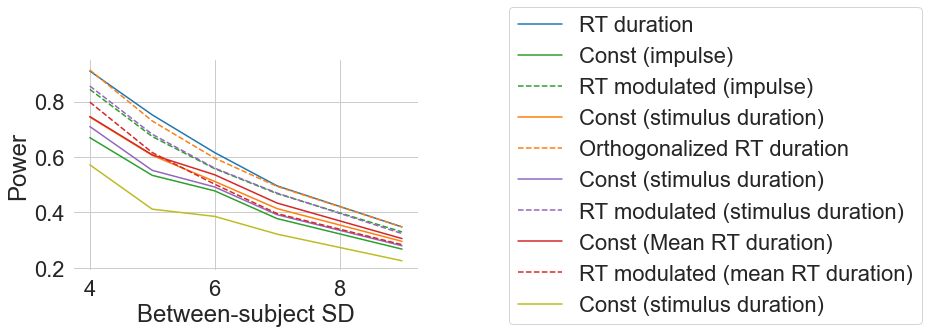

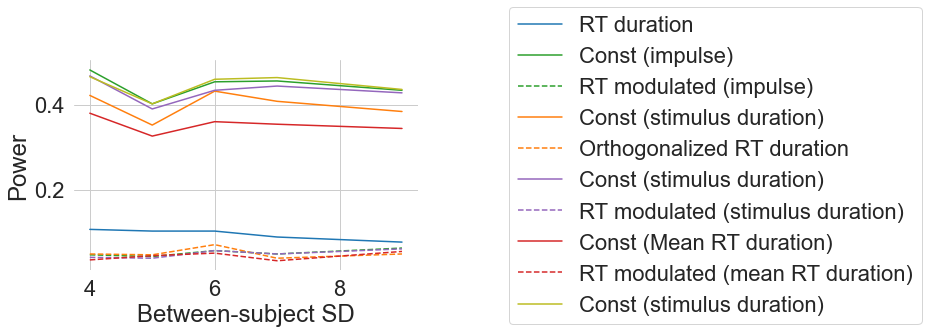

In [43]:
power_plot_group(unmod_1sampt_pow, rtmod_1sampt_pow, btwn_sub_noise_sd_vec, sim_type='dv_scales_yes',
                    zoom=False)
power_plot_group(unmod_1sampt_pow, rtmod_1sampt_pow, btwn_sub_noise_sd_vec, sim_type='dv_scales_no',
                    zoom=False)

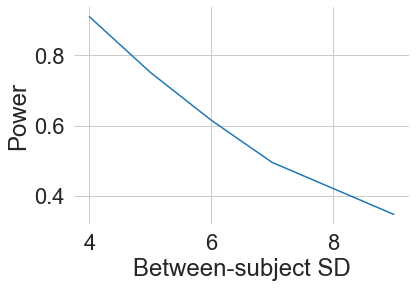

In [34]:

fig = plt.figure()
axs = plt.subplot(111, frameon=False)
#fig.add_subplot(111, frameon=False)
#plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Between-subject SD")
plt.ylabel("Power")
line1, = axs.plot(
                     btwn_sub_noise_sd_vec, 
                     rtmod_1sampt_pow['dv_scales_yes']['RT Duration only'], 
                     'tab:blue', label = 'RT duration')
#plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8, line9, line10], 
#              loc='center right', bbox_to_anchor=(3, 1/2), ncol=1)
plt.show()